In [1]:
import sqlite3
import numpy as np
import pandas as pd
from sql import run
run.prettytable.__dict__.setdefault('DEFAULT',run.prettytable.DEFAULT)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
from collections import Counter
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

C:\Users\User\AppData\Local\Temp\ipykernel_18712\3118620981.py:5: DeprecationWarning: the 'DEFAULT' constant is deprecated, use the 'TableStyle' enum instead
  run.prettytable.__dict__.setdefault('DEFAULT',run.prettytable.DEFAULT)


# FOR SEVERE DAMAGE IN DISTRICT 12

In [2]:
def wrangle(db_path):
    conn = sqlite3.connect(db_path)
    query = '''
    select distinct(i.building_id) as b_id, b.*,bu.damage_grade from id_map i
    join building_structure b on b.building_id = i.building_id
    join building_damage bu on i.building_id = bu.building_id
    where i.district_id = 12
    '''
    df = pd.read_sql(query,conn,index_col='b_id')

    drop_cols = [col for col in df.columns if 'post_eq' in col]

    df['damage_grade'] = df['damage_grade'].str[-1].astype(int)
    df['severe_damage'] = (df['damage_grade'] > 3).astype(int)

    drop_cols.append('damage_grade')
    drop_cols.append('count_floors_pre_eq')
    drop_cols.append('building_id')

    df.drop(columns=drop_cols, inplace=True)
    return df

In [60]:
# df = wrangle("C:\\Users\\User\\Downloads\\nepal_eq.db")
df.head()

,age_building,foundation_type,ground_floor_type,height_ft_pre_eq,land_surface_condition,other_floor_type,plan_configuration,plinth_area_sq_ft,position,roof_type,superstructure,severe_damage
b_id,,,,,,,,,,,,
1.201010e+11,9,Other,Mud,9,Flat,Not applicable,Rectangular,288,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,0
1.201010e+11,15,Other,Mud,9,Flat,Not applicable,Rectangular,364,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,1
1.201010e+11,20,Other,Mud,9,Flat,Not applicable,Rectangular,384,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,0
1.201010e+11,20,Other,Mud,9,Flat,Not applicable,Rectangular,312,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,0
1.201010e+11,30,Other,Mud,9,Flat,Not applicable,Rectangular,308,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,0


In [59]:
df.age_building.min()

np.int64(0)

##### df['foundation_type'].value_counts()

In [61]:
foundation_pivot = pd.pivot_table(
    df,index = 'foundation_type' , values='severe_damage',aggfunc='mean'
).sort_values(by='severe_damage',ascending=False)
foundation_pivot

,severe_damage
foundation_type,
Cement-Stone/Brick,0.353326
Mud mortar-Stone/Brick,0.350687
Bamboo/Timber,0.115512
Other,0.111111
RC,0.008889


In [7]:
major,minor = df.severe_damage.value_counts(normalize=True)

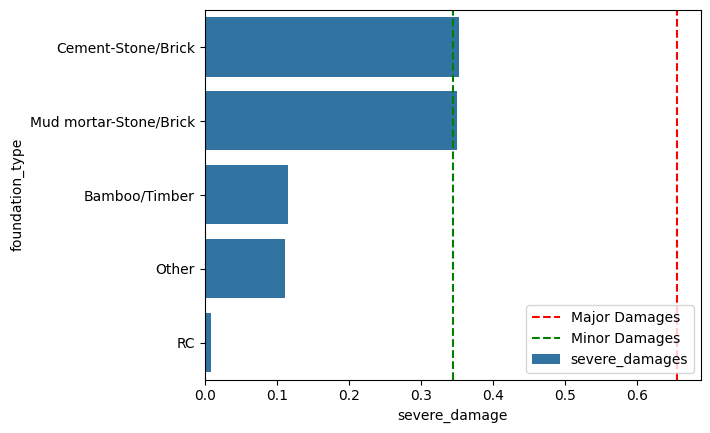

In [8]:
sns.barplot(data=foundation_pivot,x='severe_damage',y='foundation_type',label='severe_damages')
plt.axvline(
    major,linestyle='--',color='red',label='Major Damages'
)
plt.axvline(
    minor,linestyle='--',color='green',label='Minor Damages'
)
plt.legend(loc = 'lower right');

In [62]:
target = 'severe_damage'
inputs = df.drop(target,axis=1)
X = inputs
y = df[target]

In [63]:
class_counter = Counter(y_resampled)
class_counter

Counter({0: 25786, 1: 25786})

In [64]:
ros = RandomOverSampler()
X_resampled,y_resampled = ros.fit_resample(X,y)

In [66]:
df.to_csv('Nepal_district_12(severe_damamge).csv',index=False)

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=30)

In [14]:
model = Pipeline(
    [
        ('oh',OneHotEncoder(use_cat_names='mean')),
        ('ss',StandardScaler()),
        ('lr',LogisticRegression())
    ]
)

In [15]:
acc_baseline = y_test.value_counts(normalize=True).max()
acc_baseline

np.float64(0.5031507513330101)

In [21]:
acc = accuracy_score(y_test,y_predict)
acc

0.5904992729035385

In [23]:
acc = accuracy_score(y_test,y_predict)
acc

0.5904992729035385

In [18]:
model.fit(X_train,y_train)

Pipeline(steps=[('oh',
                 OneHotEncoder(cols=['foundation_type', 'ground_floor_type',
                                     'land_surface_condition',
                                     'other_floor_type', 'plan_configuration',
                                     'position', 'roof_type',
                                     'superstructure'],
                               use_cat_names='mean')),
                ('ss', StandardScaler()), ('lr', LogisticRegression())])

In [19]:
y_predict = model.predict(X_test)

In [20]:
model.score(X_train,y_train)

0.607145454104758

In [24]:
feature_importance = pd.DataFrame(
    {
        'feature': model.named_steps['oh'].get_feature_names_out(),
        'weights': np.ravel(model.named_steps['lr'].coef_)
    }
).sort_values(by='weights',ascending=False)
feature_importance.head(10)

,feature,weights
34,roof_type_Bamboo/Timber-Heavy roof,0.189490
14,land_surface_condition_Steep slope,0.123043
37,superstructure_mud_mortar_stone,0.120545
11,height_ft_pre_eq,0.088414
15,other_floor_type_Timber-Planck,0.057042
6,ground_floor_type_Mud,0.051665
3,foundation_type_Cement-Stone/Brick,0.038334
1,foundation_type_Mud mortar-Stone/Brick,0.032216
31,position_Attached-1 side,0.026437
20,plan_configuration_Square,0.021020


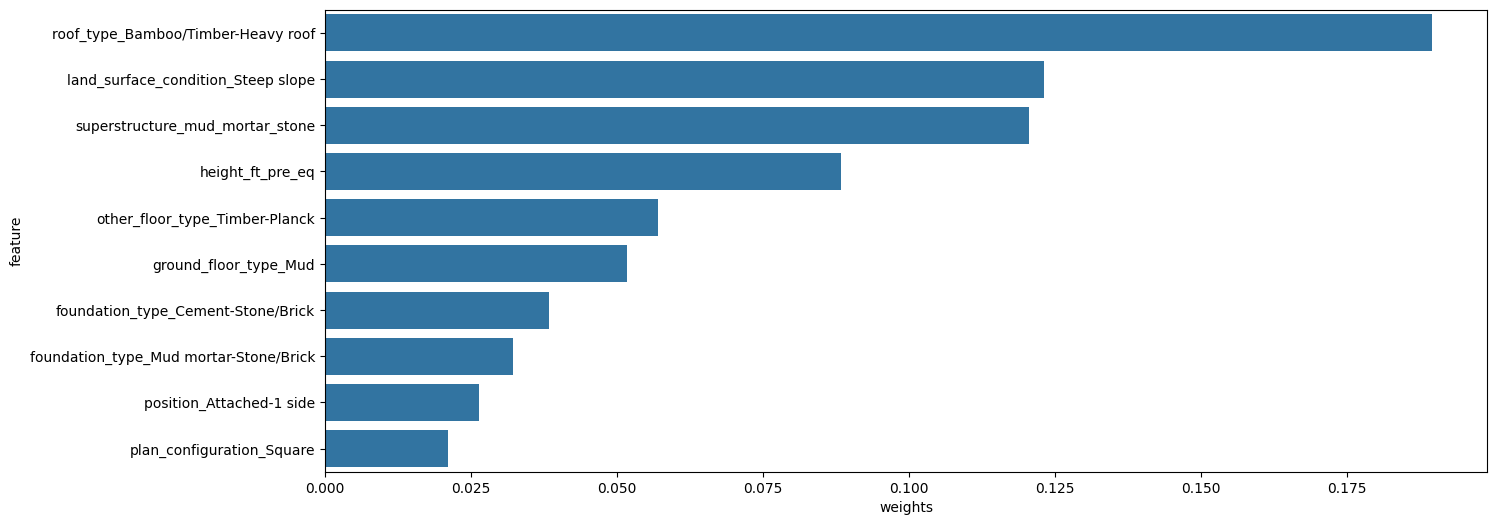

In [69]:
plt.figure(figsize=(15,6))
sns.barplot(data=feature_importance.head(10),x='weights',y='feature')
plt.savefig('Feature_importances.png')

In [33]:
model = Pipeline(
    [
        ('oh',OneHotEncoder(use_cat_names='mean')),
        ('ss',StandardScaler()),
        ('dt',DecisionTreeClassifier(random_state=30))
    ]
)

In [34]:
model.fit(X_train,y_train)

Pipeline(steps=[('oh',
                 OneHotEncoder(cols=['foundation_type', 'ground_floor_type',
                                     'land_surface_condition',
                                     'other_floor_type', 'plan_configuration',
                                     'position', 'roof_type',
                                     'superstructure'],
                               use_cat_names='mean')),
                ('ss', StandardScaler()),
                ('dt', DecisionTreeClassifier(random_state=30))])

In [35]:
y_predi = model.predict(X_test)

In [36]:
model.score(X_train,y_train)

0.9664541774729137

In [37]:
precis = precision_score(y_test,y_predi)
precis

0.7317618719889883

In [38]:
import pickle

In [39]:
with open('Nepal_12_model(severe_damage).pkl','wb') as f:
    pickle.dump(model,f)

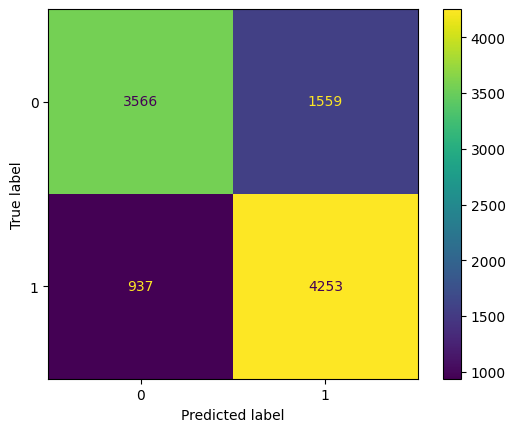

In [31]:
ConfusionMatrixDisplay.from_predictions(y_test,y_predi)

# FOR DAMAGE GRADE IN 12

In [40]:
def wrangle(db_path):
    conn = sqlite3.connect(db_path)
    query = '''
    select distinct(i.building_id) as b_id, b.*,bu.damage_grade from id_map i
    join building_structure b on b.building_id = i.building_id
    join building_damage bu on i.building_id = bu.building_id
    where i.district_id = 12
    '''
    df = pd.read_sql(query,conn,index_col='b_id')

    drop_cols = [col for col in df.columns if 'post_eq' in col]

    df['damage_grade'] = df['damage_grade'].str[-1].astype(int)
    # df['severe_damage'] = (df['damage_grade'] > 3).astype(int)

    # drop_cols.append('damage_grade')
    drop_cols.append('count_floors_pre_eq')
    drop_cols.append('building_id')

    df.drop(columns=drop_cols, inplace=True)

    foundation_pivot = pd.pivot_table(
    df,index = 'foundation_type' , values='damage_grade',aggfunc='mean'
    ).sort_values(by='damage_grade',ascending=False)
    foundation_pivot

    fig1=sns.barplot(data=foundation_pivot,x='damage_grade',y='foundation_type',label='damages_grade'),
    plt.legend(loc = 'lower right')
    plt.title("Mean Damage Grade by Foundation Type")
    plt.tight_layout()
    plt.show()

    target = 'damage_grade'
    inputs = df.drop(target,axis=1)
    X = inputs
    y = df[target]

    class_counter = Counter(y)
    class_counter
    
    ros = RandomOverSampler()
    X_resampled,y_resampled = ros.fit_resample(X,y)

    class_counter_over = Counter(y_resampled)
    
    X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=30)
    
    model = Pipeline(
    [
        ('oh',OneHotEncoder(use_cat_names='mean')),
        ('ss',StandardScaler()),
        ('dt',DecisionTreeClassifier())
    ]
    )

    acc_baseline = y_test.value_counts(normalize=True).max()
    acc_baseline

    model.fit(X_train,y_train)

    y_predict = model.predict(X_test)

    score = model.score(X_train,y_train)

    acc = accuracy_score(y_test,y_predict)
    
    precis = precision_score(y_test,y_predict,average='macro')
    
    fig2=ConfusionMatrixDisplay.from_predictions(y_test,y_predict)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    feature_importance = pd.DataFrame(
    {
        'feature': model.named_steps['oh'].get_feature_names_out(),
        'weights': model.named_steps['dt'].feature_importances_
    }
    ).sort_values(by='weights',ascending=False)
    
    fig3=sns.barplot(data=feature_importance.head(10),x='weights',y='feature')
    plt.title("Top 10 Feature Importances")
    plt.tight_layout()
    plt.show()

    print("Baseline Accuracy:", acc_baseline)
    print("Train score:", score)
    print("Test Accuracy:", acc)
    print("Macro Precision:", precis)
    return {
    'Head': df.head(),
    'Info': df.info(),  # Note: df.info() prints; doesn't return a df-like object
    "Foundation Pivot": foundation_pivot,
    "Original Class Distribution:": class_counter,
    "Oversampled Class Distribution": class_counter_over,
    "Model:": model,
    'Feature Importances': feature_importance.head(10)
    }

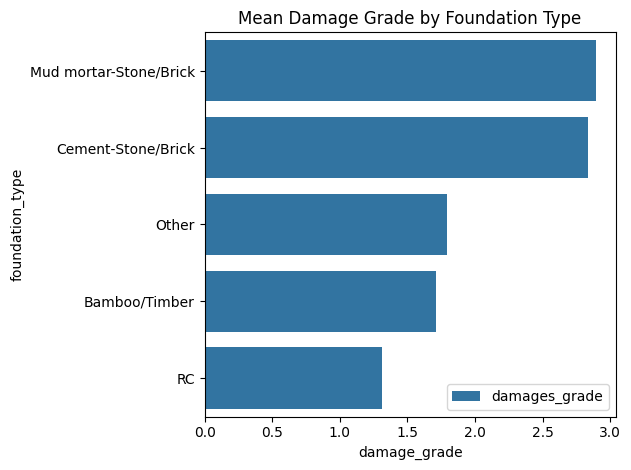

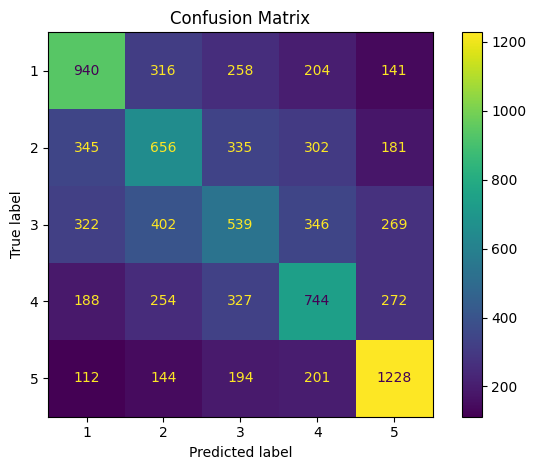

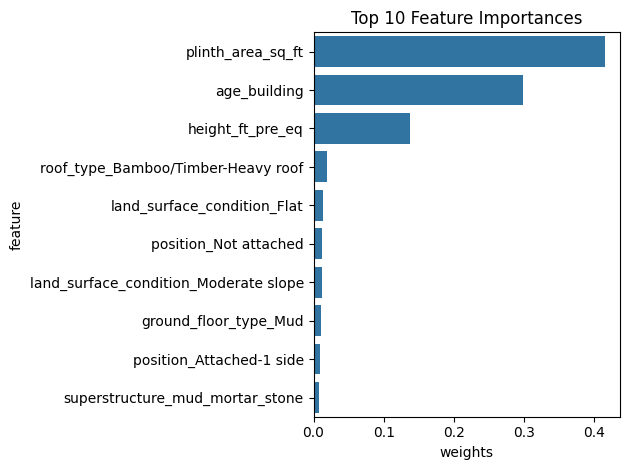

Baseline Accuracy: 0.20379609544468547
Train score: 0.9301789587852495
Test Accuracy: 0.44544468546637744
Macro Precision: 0.43809999395282045
<class 'pandas.core.frame.DataFrame'>
Index: 39352 entries, 120101000011.0 to 125609000751.0
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            39352 non-null  int64 
 1   foundation_type         39352 non-null  object
 2   ground_floor_type       39352 non-null  object
 3   height_ft_pre_eq        39352 non-null  int64 
 4   land_surface_condition  39352 non-null  object
 5   other_floor_type        39352 non-null  object
 6   plan_configuration      39352 non-null  object
 7   plinth_area_sq_ft       39352 non-null  int64 
 8   position                39352 non-null  object
 9   roof_type               39352 non-null  object
 10  superstructure          39352 non-null  object
 11  damage_grade            39352 non-null  int64 
dty

{'Head':               age_building foundation_type ground_floor_type  \
 b_id                                                           
 1.201010e+11             9           Other               Mud   
 1.201010e+11            15           Other               Mud   
 1.201010e+11            20           Other               Mud   
 1.201010e+11            20           Other               Mud   
 1.201010e+11            30           Other               Mud   
 
               height_ft_pre_eq land_surface_condition other_floor_type  \
 b_id                                                                     
 1.201010e+11                 9                   Flat   Not applicable   
 1.201010e+11                 9                   Flat   Not applicable   
 1.201010e+11                 9                   Flat   Not applicable   
 1.201010e+11                 9                   Flat   Not applicable   
 1.201010e+11                 9                   Flat   Not applicable   
 
        

In [41]:
wrangle("C:\\Users\\User\\Downloads\\nepal_eq.db")